### **Decision Tree, Random Forest, and XGBoost**

#### Necessary Imports

In [13]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.metrics import PrecisionRecallDisplay
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Plot Styling

In [14]:
# SOURCE: This plot styling is adapted from Peyton Lewis' and Aidan Cremins' Advanced Corporate Finance course's 
# Credit Ratings Analysis assigment for Professor Michael Sury.

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['axes.grid'] = True
plt.style.use('fivethirtyeight')
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

### **Decision Tree**

#### Reading in Test/Train Data

In [15]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Baseline Accuracies

In [16]:
train_baseline_accuracy = train['readmitted'].value_counts().max() / len(train['readmitted'])
test_baseline_accuracy = test['readmitted'].value_counts().max() / len(test['readmitted'])
print()
print('Train Baseline Accuracy:', format(train_baseline_accuracy, '.3%'))
print('Test Baseline Accuracy:', format(test_baseline_accuracy, '.3%'))


Train Baseline Accuracy: 61.173%
Test Baseline Accuracy: 61.815%


#### Establishing Train/Test Data

In [17]:
X_train = train.drop(columns= ['readmitted'])
y_train = train['readmitted']
X_test = test.drop(columns= ['readmitted'])
y_test = test['readmitted']

#### Evaluation Metric Functions

In [18]:
# SOURCE: This confusion matrix code is adapted from Peyton Lewis' and Aidan Cremins' Advanced Corporate Finance course's 
# Credit Ratings Analysis assigment for Professor Michael Sury.

def create_confusion_matrix(test_vals, pred_vals, model_name):

    conf_mat = confusion_matrix(test_vals, pred_vals)

    sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    
    #Change the 0's and 1's to the actual class names for clearer interpretation
    plt.xticks(ticks=[0.5,1.5], labels=['Not Readmitted','Readmitted'])
    plt.yticks(ticks=[0.5,1.5], labels=['Not Readmitted','Readmitted'])
    plt.title('Confusion Matrix for {} Model'.format(model_name))

In [19]:
# SOURCE: This ROC curve code is adapted from Peyton Lewis' and Aidan Cremins' Advanced Corporate Finance course's 
# Credit Ratings Analysis assigment for Professor Michael Sury.

def create_roc_curve(model, x_test, y_test, model_name):
    metrics.plot_roc_curve(model, x_test, y_test, name=model_name)
    plt.plot([0,1],[0,1], linestyle='--', label='Baseline Classifier',color = 'red')
    plt.grid()
    plt.legend()

In [20]:
# SOURCE: This PR curve code is adapted from Peyton Lewis' and Aidan Cremins' Advanced Corporate Finance course's 
# Credit Ratings Analysis assigment for Professor Michael Sury.

def create_pr_curve(model, x_test, y_test, model_name):
    metrics.plot_precision_recall_curve(model, x_test, y_test, name=model_name)
    positive_rate = sum(y_test)/len(y_test)
    plt.plot([0,1],[positive_rate,positive_rate], linestyle='--', label='Baseline Classifier',color = 'red')
    plt.grid()
    plt.legend()

#### Decision Tree Model: Symmetric Costs

Accuracy Score: 0.7782255674746636
              precision    recall  f1-score   support

           0       0.78      0.88      0.83     10430
           1       0.76      0.61      0.68      6443

    accuracy                           0.78     16873
   macro avg       0.77      0.75      0.75     16873
weighted avg       0.78      0.78      0.77     16873



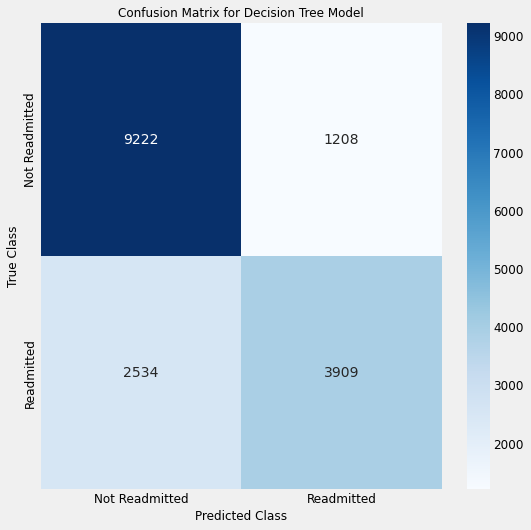

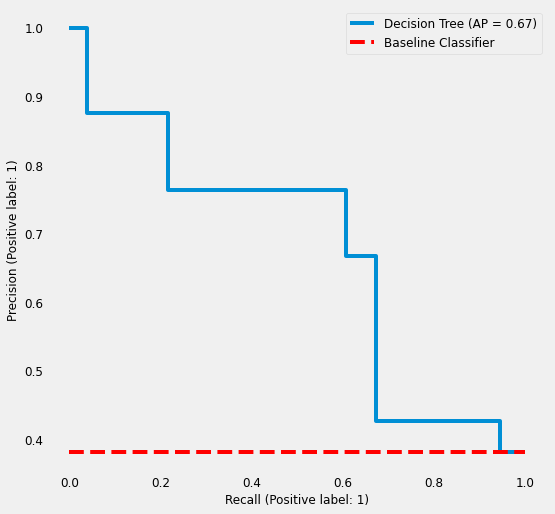

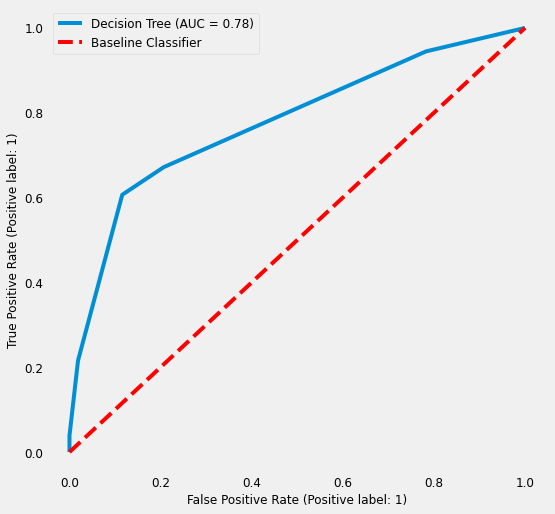

In [21]:
# Fitting Decision Tree without Hyperparameter Tuning
dtree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 1)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
create_confusion_matrix(y_test, y_pred, 'Decision Tree')
create_pr_curve(dtree, X_test, y_test, 'Decision Tree')
create_roc_curve(dtree, X_test, y_test, 'Decision Tree')

#### Decision Tree: Asymmetric Costs

Accuracy Score: 0.7541634564096485
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     10430
           1       0.68      0.66      0.67      6443

    accuracy                           0.75     16873
   macro avg       0.74      0.74      0.74     16873
weighted avg       0.75      0.75      0.75     16873



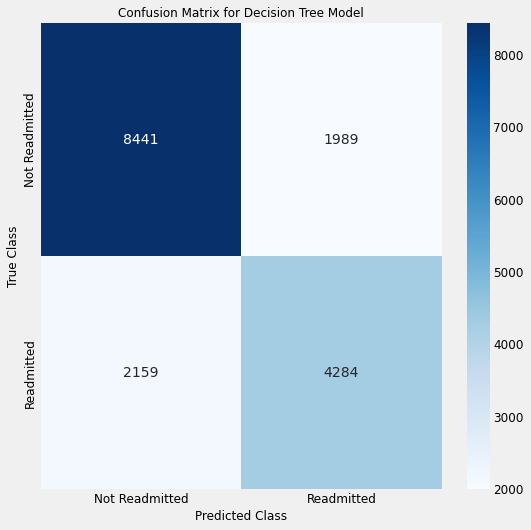

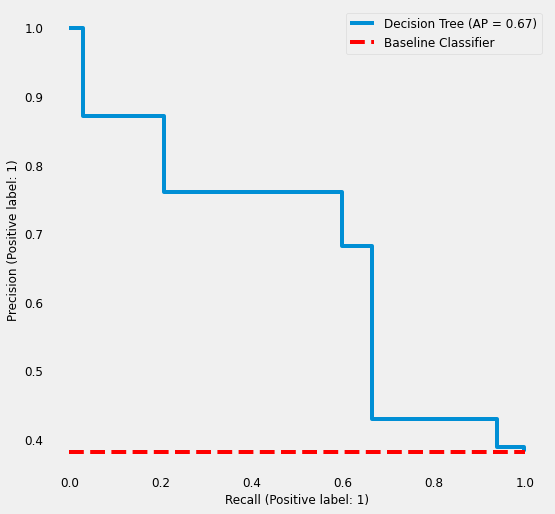

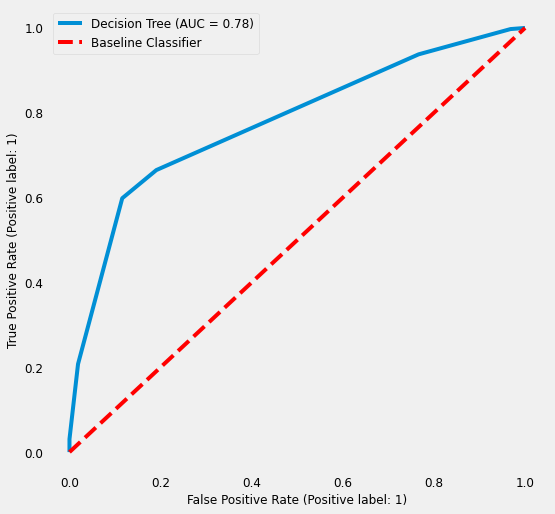

In [22]:
# Fitting Decision Tree without Hyperparameter Tuning
dtree2 = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 1, class_weight = {0:1, 1:2})
dtree2.fit(X_train, y_train)
y_pred2 = dtree2.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))
create_confusion_matrix(y_test, y_pred2, 'Decision Tree')
create_pr_curve(dtree2, X_test, y_test, 'Decision Tree')
create_roc_curve(dtree2, X_test, y_test, 'Decision Tree')

In [23]:
# Feature Importance of Decision Tree
index = X_train.columns.to_list()
feat_imp_tree = pd.DataFrame()
feat_imp_tree['feature'] = index
feat_imp_tree['importance'] = dtree.feature_importances_
feat_imp_tree = feat_imp_tree.sort_values(by=['importance'], ascending=False)
feat_imp_tree.head()

,feature,importance
6,number_inpatient,0.920799
4,number_outpatient,0.056098
7,number_diagnoses,0.023103
0,time_in_hospital,0.000000
37,diag_2_Injury,0.000000


### **Random Forest**

#### Random Forest Model: Symmetric Costs

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] END .......................max_depth=5, n_estimators=50; total time=   1.7s
[CV] END .......................max_depth=5, n_estimators=50; total time=   1.7s
[CV] END .......................max_depth=5, n_estimators=50; total time=   1.7s
[CV] END .......................max_depth=5, n_estimators=50; total time=   1.7s
[CV] END .......................max_depth=5, n_estimators=50; total time=   1.7s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.2s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.3s
[CV] END ......................max_depth=5, n_estimators=200; total time=   6.3s
[CV] END ......................max_depth=5, n_e

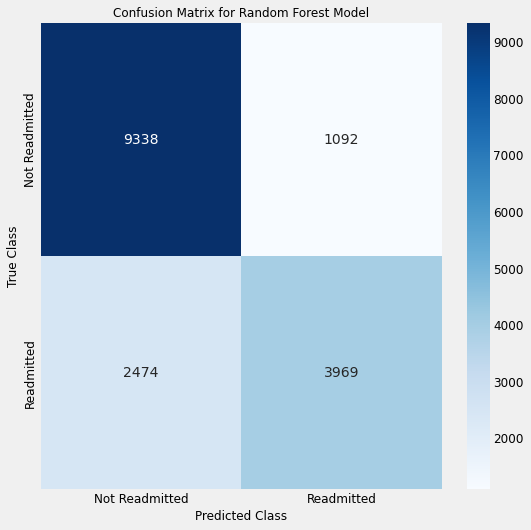

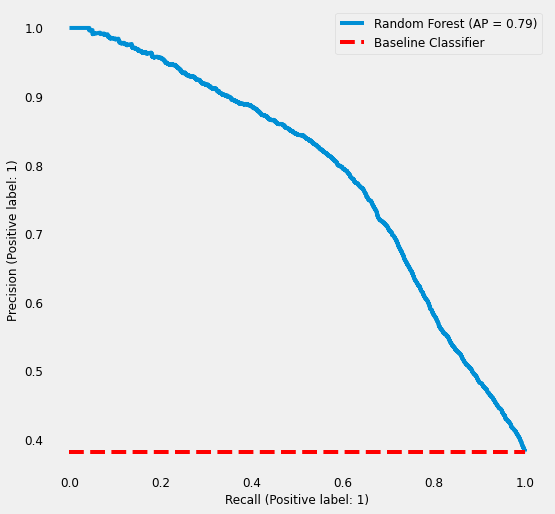

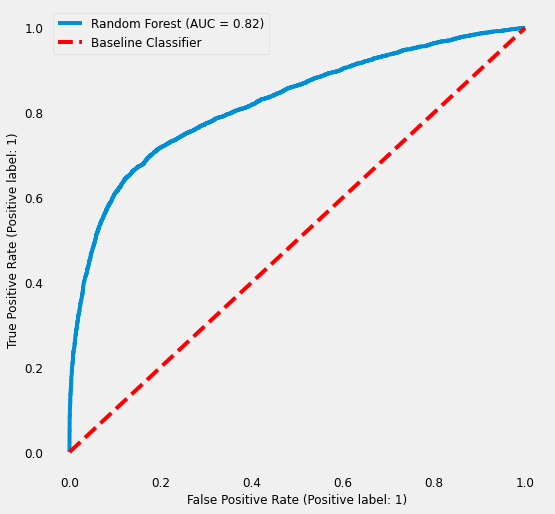

In [24]:
# SOURCE: This code is adapted from Peyton Lewis' and Aidan Cremins' Advanced Corporate Finance course's
# Credit Ratings Analysis assigment for Professor Michael Sury.

n_estimators = [50, 100, 200, 300, 500] 
max_depth = [5, 10, 20, 30, 40, 50, 100]

grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
rf_mod_tuned = RandomForestClassifier(random_state=1)
rf_mod_tuned = GridSearchCV(estimator = rf_mod_tuned, param_grid = grid,
               cv = 5, verbose=2, n_jobs = -1)
rf_mod_tuned_fitted = rf_mod_tuned.fit(X_train,y_train)
print('Best Parameters: ', rf_mod_tuned.best_params_)
rf_mod_tuned_pred = rf_mod_tuned_fitted.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, rf_mod_tuned_pred))
print(classification_report(y_test, rf_mod_tuned_pred))
create_confusion_matrix(y_test, rf_mod_tuned_pred, 'Random Forest')
create_pr_curve(rf_mod_tuned_fitted, X_test, y_test, 'Random Forest')
create_roc_curve(rf_mod_tuned_fitted, X_test, y_test, 'Random Forest')

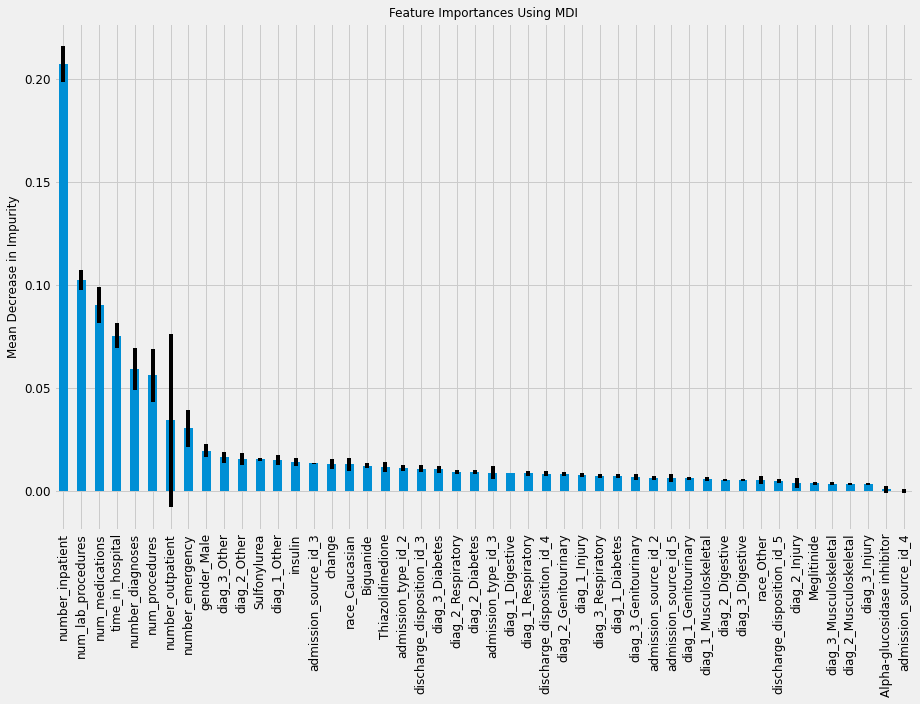

In [25]:
# Fit the RF model with the best parameters
best_params = rf_mod_tuned.best_params_
rf_mod_tuned = RandomForestClassifier(n_estimators = best_params['n_estimators'], max_depth = best_params['max_depth'], random_state=1)
rf_mod_tuned.fit(X_train, y_train)

# Feature importance for Random Forest
importances = rf_mod_tuned.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_mod_tuned.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns.to_list()).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(13, 10))
forest_importances.plot.bar(yerr=std, ax=ax,)
ax.set_title("Feature Importances Using MDI")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

#### Random Forest Model: Asymmetric Costs

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] END .......................max_depth=5, n_estimators=50; total time=   1.6s
[CV] END .......................max_depth=5, n_estimators=50; total time=   1.7s
[CV] END .......................max_depth=5, n_estimators=50; total time=   1.8s
[CV] END .......................max_depth=5, n_estimators=50; total time=   1.8s
[CV] END .......................max_depth=5, n_estimators=50; total time=   1.8s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.2s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.4s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.8s
[CV] END ......................max_depth=5, n_estimators=100; total time=   3.4s
[CV] END ......................max_depth=5, n_estimators=200; total time=   7.1s
[CV] END ......................max_depth=5, n_e

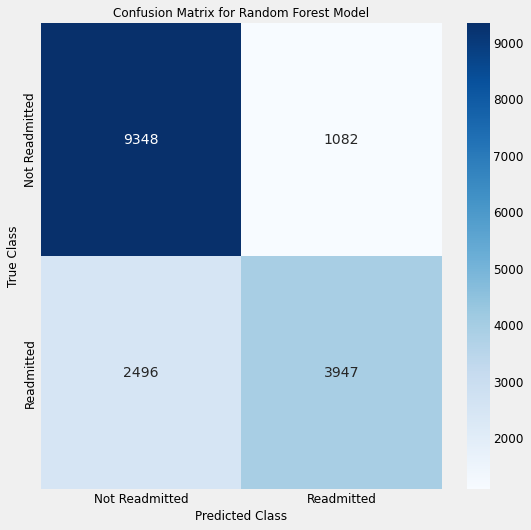

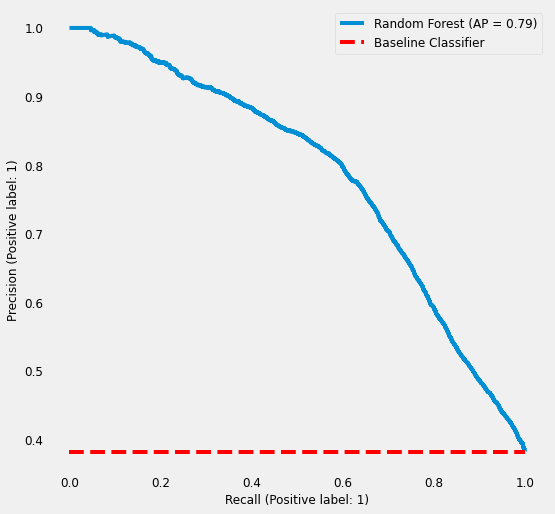

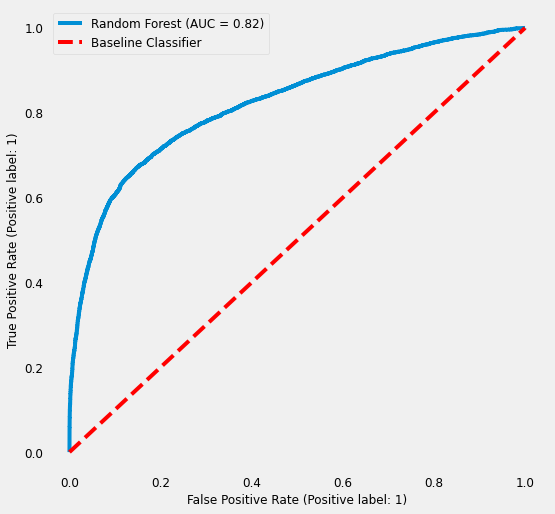

In [26]:
# SOURCE: This code is adapted from Peyton Lewis' and Aidan Cremins' Advanced Corporate Finance course's
# Credit Ratings Analysis assigment for Professor Michael Sury.

n_estimators = [50, 100, 200, 300, 500] 
max_depth = [5, 10, 20, 30, 40, 50, 100]

grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
rf_mod_tuned2 = RandomForestClassifier(random_state = 1, class_weight = {0:1, 1:2})
rf_mod_tuned2 = GridSearchCV(estimator = rf_mod_tuned2, param_grid = grid,
               cv = 5, verbose=2, n_jobs = -1)
rf_mod_tuned_fitted2 = rf_mod_tuned2.fit(X_train,y_train)
print('Best Parameters: ', rf_mod_tuned2.best_params_)
best_params2 = rf_mod_tuned2.best_params_
rf_mod_tuned_pred2 = rf_mod_tuned_fitted2.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, rf_mod_tuned_pred2))
print(classification_report(y_test, rf_mod_tuned_pred2))
create_confusion_matrix(y_test, rf_mod_tuned_pred2, 'Random Forest')
create_pr_curve(rf_mod_tuned_fitted2, X_test, y_test, 'Random Forest')
create_roc_curve(rf_mod_tuned_fitted2, X_test, y_test, 'Random Forest')

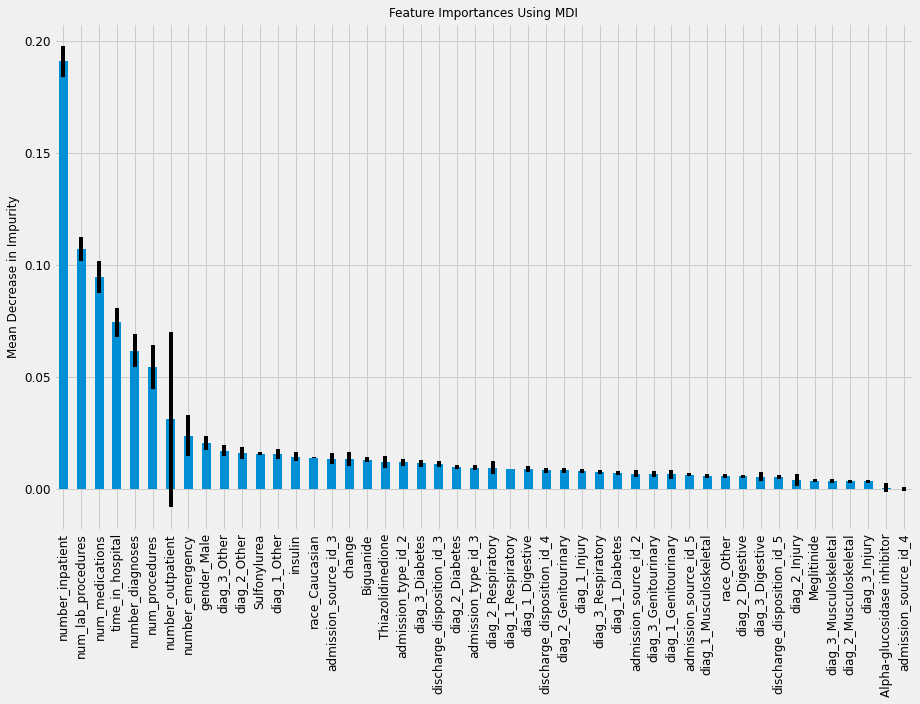

In [27]:
# Fit the RF model with the best parameters
rf_mod_tuned2 = RandomForestClassifier(n_estimators = best_params2['n_estimators'], max_depth = best_params2['max_depth'], random_state=1, class_weight={0:1, 1:2})
rf_mod_tuned2.fit(X_train, y_train)

# Feature importance for Random Forest
importance2 = rf_mod_tuned2.feature_importances_
std2 = np.std([tree.feature_importances_ for tree in rf_mod_tuned2.estimators_], axis=0)
forest_importances2 = pd.Series(importance2, index = X_train.columns.to_list()).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(13, 10))
forest_importances2.plot.bar(yerr=std2, ax=ax,)
ax.set_title("Feature Importances Using MDI")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

### **XGBoost**

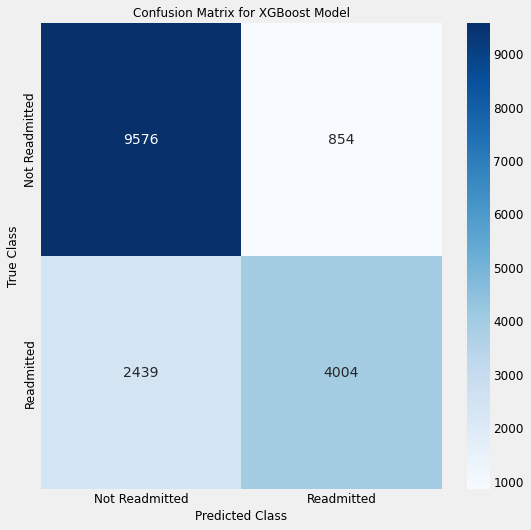

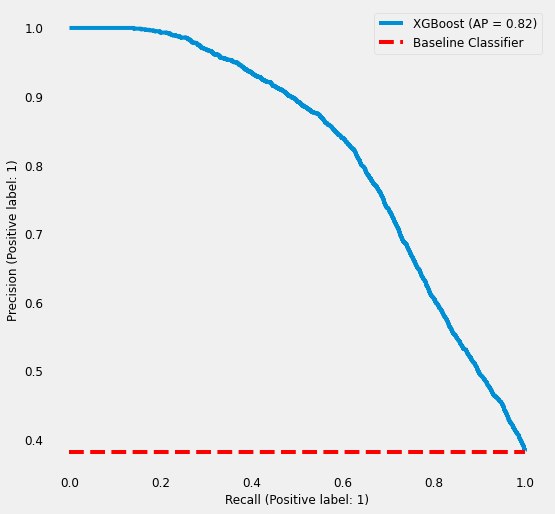

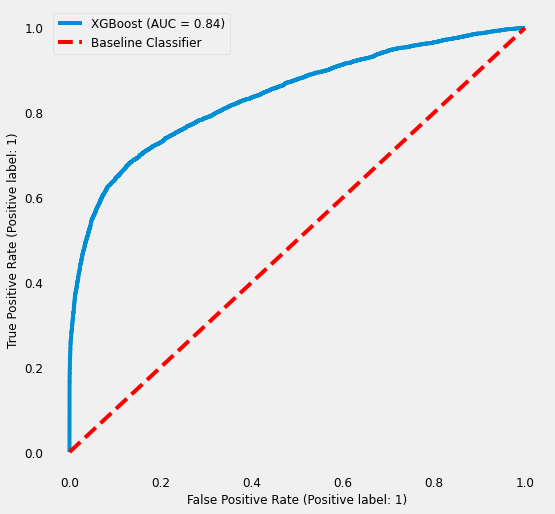

In [28]:
xgb_mod = xgb.XGBClassifier(seed=1)
#Grid adapted from https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [1000],
           'colsample_bytree': [0.3, 0.7]}
tuning_grid = GridSearchCV(xgb_mod, params)
tuning_grid.fit(X_train,y_train)
xgb_mod = tuning_grid.best_estimator_
xgb_mod.fit(X_train,y_train)
xgb_pred = xgb_mod.predict(X_test)
create_confusion_matrix(y_test, xgb_pred, 'XGBoost')
create_pr_curve(xgb_mod, X_test, y_test, 'XGBoost')
create_roc_curve(xgb_mod, X_test, y_test, 'XGBoost')

### Asymmetric Costs
Link used: https://stackoverflow.com/questions/67868420/xgboost-for-multiclassification-and-imbalanced-data

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
0.7860796790546996
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1, ...)


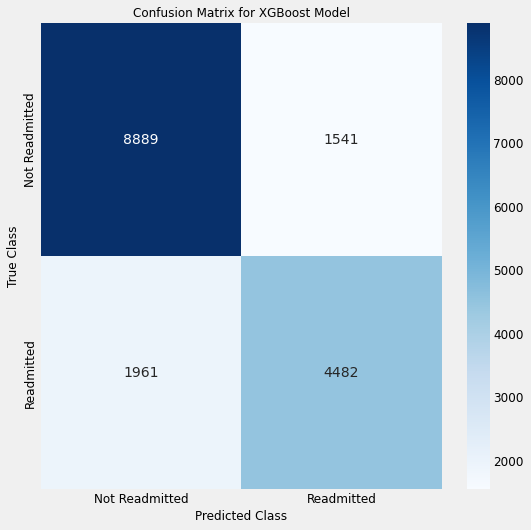

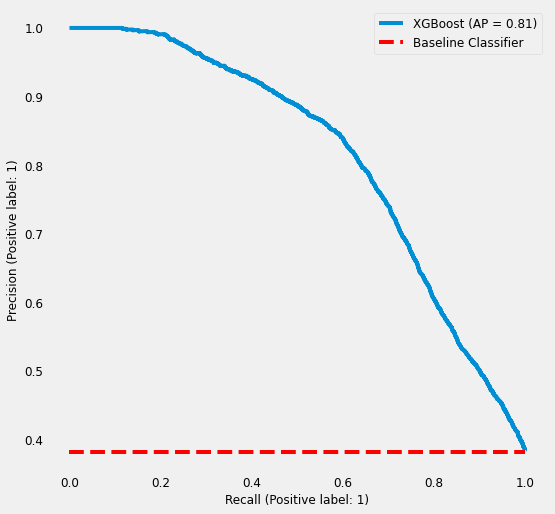

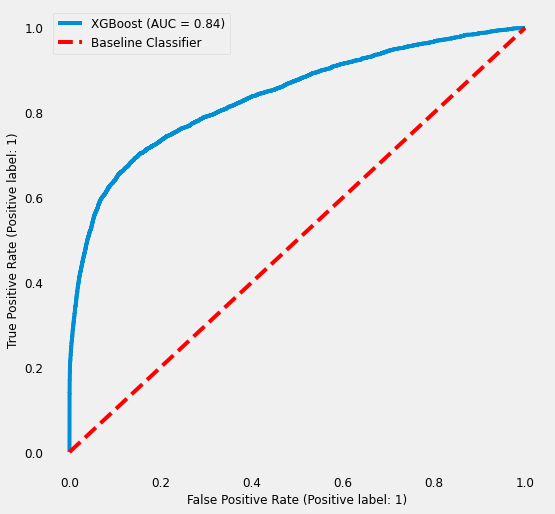

In [29]:
xgb_model_asymmetric = xgb.XGBClassifier(seed=1)
#Grid adapted from https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [1000],
           'colsample_bytree': [0.3, 0.7]
           }

grid = GridSearchCV(xgb_model_asymmetric, params, cv=5, n_jobs=-1, verbose=1)
#Implementing the imbalanced 2:1 costs
grid.fit(X_train, y_train, sample_weight=np.where(y_train==1,2,1))

# print best parameters
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

#Fit the model with the optimal parameters
xgb_model_asymmetric = xgb.XGBClassifier(colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=1000)
xgb_model_asymmetric.fit(X_train, y_train, sample_weight=np.where(y_train==1,2,1))
xgb_pred_asymmetric = xgb_model_asymmetric.predict(X_test)

create_confusion_matrix(y_test, xgb_pred_asymmetric, 'XGBoost')
create_pr_curve(xgb_model_asymmetric, X_test, y_test, 'XGBoost')
create_roc_curve(xgb_model_asymmetric, X_test, y_test, 'XGBoost')

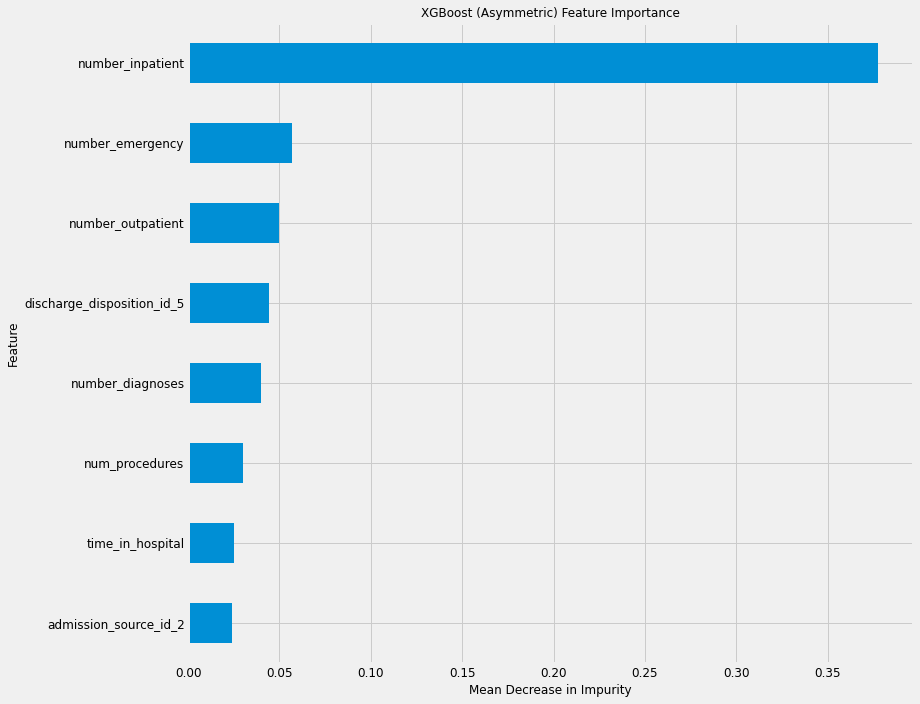

In [30]:
# Feature importance for XGBoost
importance3 = xgb_model_asymmetric.feature_importances_
forest_importances3 = pd.Series(importance3, index = X_train.columns.to_list()).sort_values(ascending=False)[:8]
fig, ax = plt.subplots(figsize=(13, 10))
forest_importances3.plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_title("XGBoost (Asymmetric) Feature Importance")
ax.set_xlabel("Mean Decrease in Impurity")
ax.set_ylabel("Feature")
fig.tight_layout()

### ROC and PR Curves

#### ROC Curves

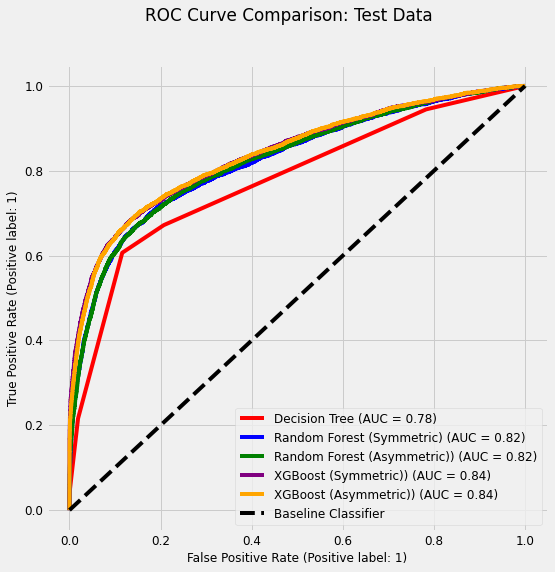

In [31]:
# Plot ROC curves
plot = RocCurveDisplay.from_estimator(dtree, X_test,y_test, name='Decision Tree', color = 'red')
plot = RocCurveDisplay.from_estimator(rf_mod_tuned, X_test, y_test, ax=plot.ax_, name='Random Forest (Symmetric)', color = 'blue')
plot = RocCurveDisplay.from_estimator(rf_mod_tuned2, X_test, y_test, ax=plot.ax_, name='Random Forest (Asymmetric))', color = 'green')
plot = RocCurveDisplay.from_estimator(xgb_mod, X_test, y_test, ax=plot.ax_, name='XGBoost (Symmetric))', color = 'purple')
plot = RocCurveDisplay.from_estimator(xgb_model_asymmetric, X_test, y_test, ax=plot.ax_, name='XGBoost (Asymmetric))', color = 'orange')
#plot = RocCurveDisplay.from_estimator(xg_boost, X_test, y_test,ax=plot.ax_)
plot.ax_.plot([0, 1], [0, 1], linestyle='--', label ='Baseline Classifier', color='black')
plot.figure_.suptitle("ROC Curve Comparison: Test Data")
plot.ax_.legend(loc='lower right')
plot

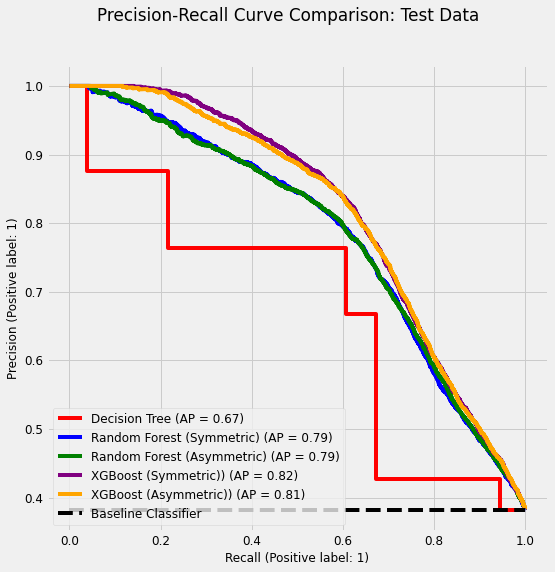

In [32]:
# Plot PR curves
fig = PrecisionRecallDisplay.from_estimator(dtree, X_test,y_test, name='Decision Tree', color = 'red')
fig = PrecisionRecallDisplay.from_estimator(rf_mod_tuned, X_test, y_test, ax=fig.ax_, name='Random Forest (Symmetric)', color = 'blue')
fig = PrecisionRecallDisplay.from_estimator(rf_mod_tuned2, X_test, y_test, ax=fig.ax_, name = "Random Forest (Asymmetric)", color = 'green')
fig = PrecisionRecallDisplay.from_estimator(xgb_mod, X_test, y_test, ax=fig.ax_, name='XGBoost (Symmetric))', color = 'purple')
fig = PrecisionRecallDisplay.from_estimator(xgb_model_asymmetric, X_test, y_test, ax=fig.ax_, name='XGBoost (Asymmetric))', color = 'orange')
#Add baseline model
fig.ax_.plot([0, 1], [1-test_baseline_accuracy, 1-test_baseline_accuracy], linestyle='--', label ='Baseline Classifier', color='black')
fig.figure_.suptitle("Precision-Recall Curve Comparison: Test Data")
# put legend in the top right corner
fig.ax_.legend(loc='lower left')
plt.show()